## Multi-label classification with BERT

Transformers and their offsprings (BERT, GPT-3, T5, ...) have [revolutionized NLP](https://blog.seekwell.io/gpt3) and, in my opinion, seem to take us closer to [Artificial General Intelligence](https://en.wikipedia.org/wiki/Artificial_general_intelligence). Thanks to [Hugging Face 🤗](https://huggingface.co/), fine-tuning transformers on your data set now boils down to a couple of lines of Python code. 

<figure>
<center>
<img src='https://i0.wp.com/syncedreview.com/wp-content/uploads/2020/03/BERT-LANG-STREET.png?fit=3264%2C2448&ssl=1' height="200"/>
<figcaption>BERT's family</figcaption></center>
</figure>

Some use cases still require a bit of tinkering, like the multi-label classification  problem I had to tackle recently. In this article I'm sharing my TensorFlow implementation which is portable to any other transformer you may prefer. If you are more of a PyTorch afficionado, feel free to have a look at [this blog post instead](https://towardsdatascience.com/transformers-for-multilabel-classification-71a1a0daf5e1).

Today's post is not theoretical. If you want to dive into the inner workings of transformers there's a lot of good presentations on Transformers out there, notably [Transformer illustrated](http://jalammar.github.io/illustrated-transformer/), [Transformers from scratch](http://peterbloem.nl/blog/transformers), and [the annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html). 

In my experience exploring the Transformers litterature, the Transformer itself is the most complex component and the one that took me the most time to understand. With a solid understanding of the Transformer subsequent models built on top of it are fairly easy to grasp (like [BERT](https://arxiv.org/abs/1810.04805), the [GPT](https://arxiv.org/abs/2005.14165) family, and [maaaaaannnny others](https://huggingface.co/models)).

In this blog post I fine-tune [DistillBERT](https://arxiv.org/abs/1910.01108) (a smaller version of BERT with very close performances) on the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data). This challenge consists in tagging Wikipedia comments according to several "toxic behavior" labels. The task is a multi-label classification problem because a single comment can have zero, one, or up to six tags.

As you'll see below, I simply fine-tuned the model on a GPU (thanks to [Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true)) and achieved very good performances in less than an hour.

## Import and prepare the dataset

In [1]:
%%capture  # Ignore the cell output
!pip uninstall -y -q kaggle && pip install -q kaggle 
# Needed to get the latest version of the Kaggle CLI

from getpass import getpass
import os

# We'll use the Kaggle-CLI to download the dataset
# To create an authentication token on Kaggle check https://www.kaggle.com/docs/api
# You'll also have to accept the competition rules here: 
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/rules

os.environ["KAGGLE_USERNAME"] = getpass(prompt='Kaggle username: ')
os.environ["KAGGLE_KEY"] = getpass(prompt='Token: ')

!kaggle --version
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!unzip jigsaw-toxic-comment-classification-challenge.zip && unzip train.csv.zip

Kaggle username: ··········
Token: ··········


The above cell is just meant to download and unpack the data, now let's load and prepare the dataset.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

dataset = pd.read_csv("train.csv")
texts = list(dataset["comment_text"])
label_names = dataset.drop(["id", "comment_text"], axis=1).columns
labels = dataset[label_names].values

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

sample_idx = 23
print(f'Sample: "{train_texts[sample_idx]}"')
print(f"Labels: {pd.Series(train_labels[sample_idx], label_names).to_dict()}")

Sample: "what the fuck who deleted the spider loc and hot rod sections fucking wikipedia stupid ass ignorant people can we get it back ?"
Labels: {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}


## A minimalistic Exploratory Data Analysis

Here we'll just have a look at the texts length distribution. That will help us choose a reasonable cut-off for number of words, in order to speed up training (the maximum is 512 for BERT).

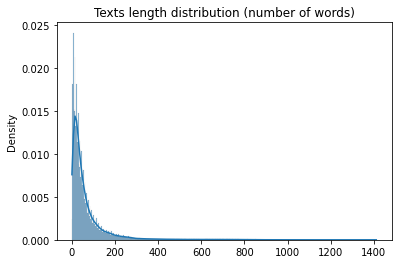

In [ ]:
import seaborn as sns

text_lengths = [len(t.split()) for t in train_texts]
ax = sns.histplot(data=text_lengths, kde=True, stat="density")
ax.set_title("Texts length distribution (number of words)");

Let's choose a cutoff of 200 words, since most 
texts are shorter than this.

You'll see below that the labels are pretty imbalanced, it gives us an idea of the order of magnitude of what a decent accuracy could be.

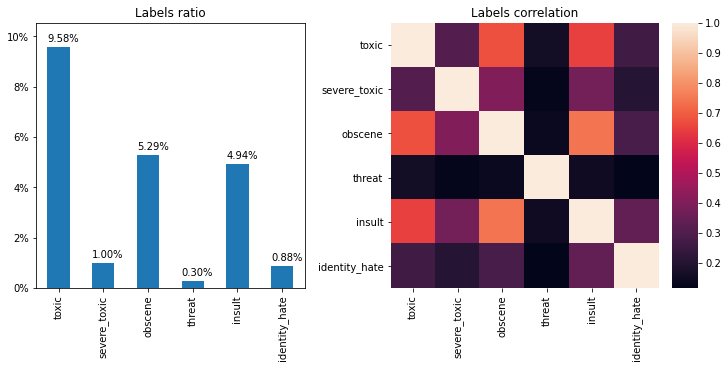

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Labels distribution barplot
labels_ratio = dataset[label_names].mean()
labels_ratio.plot(kind="bar", ax=ax1)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=False))
for p in ax1.patches:
    ax1.set_ylim(0, 1.1 * labels_ratio.max())
    ax1.annotate(f"{p.get_height():.2%}", (p.get_x() + 0.005, p.get_height() + 0.002))
ax1.set_title("Labels ratio");

# Labels correlation heatmap
ax2 = sns.heatmap(dataset[label_names].corr())
ax2.set_title("Labels correlation")
fig.show()

Note that labels are largely correlated. It should make traning easier since the patterns learned by the transformer will generalize accross labels.

For benchmark purpose it is always useful to know the performance of a dummy classifier that always predicts the label ratio as the label probability. Note that for multi-label classification we make a distinction between the accuracy (all predicted labels are correct) and the binary accuracy (how many *individual labels* are correct). The latter is always larger than the former because it is harder to predict **all** labels correctly.

In [15]:
import numpy as np  
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss

pd.set_option("display.precision", 3)

dummy = DummyClassifier(strategy="prior")
dummy.fit(train_texts, train_labels)
y_pred = dummy.predict(test_texts)
y_prob = dummy.predict_proba(test_texts)
y_prob = np.array(y_prob)[:, :, 1].T

def compute_metrics(y_true, y_prob):
    y_pred = y_prob.round()
    metrics = dict()
    metrics["accuracy"] = np.all(y_pred == y_true, axis=1).mean()
    metrics["binary_accuracy"] = (y_pred == y_true).mean()
    metrics["loss"] = log_loss(y_true, y_prob)
    return pd.Series(metrics)

metrics = compute_metrics(test_labels, y_prob)
metrics.name = "Dummy classifier"
print(metrics.to_markdown())

|                 |   Dummy classifier |
|:----------------|-------------------:|
| accuracy        |           0.898355 |
| binary_accuracy |           0.963058 |
| loss            |           0.302386 |


## Setting a baseline

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

# We take into account unigrams and bigrams that occur at least 10 times 
# in the train set, but less than 50 % of the time
tfidf = TfidfVectorizer(min_df=10, max_df=0.5, ngram_range=(1, 2))

# We set the (L2) regularization weight to 1/2 (inverse of C)
classifier = OneVsRestClassifier(LogisticRegression(C=2., max_iter=1000))

baseline = make_pipeline(tfidf, classifier)
baseline.fit(train_texts, train_labels)

y_prob = baseline.predict_proba(test_texts)

metrics = compute_metrics(test_labels, y_prob)
metrics.name = "TF-IDF + Logistic Regression"
print(metrics.to_markdown())

|                 |   TF-IDF + Logistic Regression |
|:----------------|-------------------------------:|
| accuracy        |                       0.91938  |
| binary_accuracy |                       0.980871 |
| loss            |                       0.280769 |


So we have a small improvement over the random baseline, let's se how transformers perform on this task. 

## Fine-tuning DistillBERT

The [Transformers package](https://huggingface.co/transformers/) provides pre-trained transformer-based models, plus the corresponding pre-processing and tokenizing functions (the tokenizers even have optimized implementations in Rust!).

In [30]:
!pip install -q transformers > /dev/null

import transformers
print(f"Transformers package version: {transformers.__version__}")

Transformers package version: 4.2.2


In [ ]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification, \
    DistilBertConfig, DistilBertTokenizerFast

MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 200  # We truncate anything after the 200-th word to speed up training

# The configuration is not needed if you don't have to customize the 
# network architecture. Here we will need it to replacee the output of the model
# with a multi-label prediction layer (i.e. sigmoid activations + binary cross-entropy
# instead of softmax + categorical cross-entropy of multi-class classification)
config = DistilBertConfig.from_pretrained(MODEL_NAME)

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)


train_encodings = tokenizer(train_texts, truncation=True, padding=True, 
                            max_length=MAX_LENGTH, return_tensors="tf")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, 
                           max_length=MAX_LENGTH, return_tensors="tf")

# Create TensorFlow datasets to feed the model for training and evaluation
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))

# Tokenizer output example
sample_text = "I have changed the headers to small letters, since I was basically..."
tokenizer.decode(tokenizer(sample_text)["input_ids"])

'[CLS] i have changed the headers to small letters, since i was basically... [SEP]'

The "[CLS]" special token is prepended to each text and will be used for classification, and a "[SEP]" token is appended. 

Note that thanks to BERT adding customizable special tokens, you can also take into account custom vocabularies that maybe specific to your dataset (e.g. domain-specific tags, or unusual characters with a specific meaning). To do so,you just have to add the following line `tokenizer.add_special_tokens({"additional_special_tokens": ["[unused1]"]})` and map your custom symbols to "[unused1]" (or "[unused2]", ..., up to "[unused999]"). We won't need it here.

Now that the tokenizer is available, we have to customize the output of the BERT model for our multi-label problem.

In [ ]:
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

transformer_model = TFDistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, output_hidden_states=False
)

bert = transformer_model.layers[0]

# The input is a dictionary of word identifiers 
input_ids = Input(shape=(MAX_LENGTH,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Here we select the representation of the first token ([CLS]) for classification
# (a.k.a. "pooled representation")
bert_model = bert(inputs)[0][:, 0, :] 

# Add a dropout layer and the output layer
dropout = Dropout(config.dropout, name='pooled_output')
pooled_output = dropout(bert_model, training=False)
output = Dense(
    units=train_labels.shape[1],
    kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
    activation="sigmoid",  # Choose a sigmoid for multi-label classification
    name='output'
)(pooled_output)

model = Model(inputs=inputs, outputs=output, name='BERT_MultiLabel')
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Model: "BERT_MultiLabel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
distilbert (TFDistilBertMain TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
output (Dense)               (None, 6)                 4614      
Total params: 66,367,494
Trainable params: 66,367,494
Non-trainable params: 0
_________________________________________________________________


So we will fine-tune ~66M parameters on our dataset. That may sound like a lot, and one may be concerned with overfitting risks, but BERT has proven very robust to fine-tuning. 

Now we can train the model in a few lines of code!

In [ ]:
loss = BinaryCrossentropy()
optimizer = Adam(5e-5)
metrics = ["accuracy", "binary_accuracy"]
 
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
training_history = model.fit(
    train_dataset.shuffle(1000).batch(16), epochs=3, batch_size=16, 
    validation_data=test_dataset.batch(16)
)

Epoch 1/3


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['attention_mask'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


7979/7979 [==============================] - 1753s 219ms/step - loss: 0.0619 - accuracy: 0.9315 - binary_accuracy: 0.9790 - val_loss: 0.0448 - val_accuracy: 0.9921 - val_binary_accuracy: 0.9815
Epoch 2/3
7979/7979 [==============================] - 1735s 217ms/step - loss: 0.0376 - accuracy: 0.9496 - binary_accuracy: 0.9849 - val_loss: 0.0400 - val_accuracy: 0.9922 - val_binary_accuracy: 0.9842
Epoch 3/3
7979/7979 [==============================] - 1744s 219ms/step - loss: 0.0311 - accuracy: 0.9211 - binary_accuracy: 0.9874 - val_loss: 0.0442 - val_accuracy: 0.9897 - val_binary_accuracy: 0.9846


The model achieves a good accuracy compared to the random model, and to the baseline. Let's run the evaluate method on the test set once more, as a sanity check.

In [ ]:
benchmarks = model.evaluate(
    test_dataset.batch(16), return_dict=True, batch_size=16
)
benchmarks

1995/1995 [==============================] - 143s 71ms/step - loss: 0.0442 - accuracy: 0.9897 - binary_accuracy: 0.9846


{'accuracy': 0.989722728729248,
 'binary_accuracy': 0.9846078157424927,
 'loss': 0.044167641550302505}

~99 % accuracy and binary accuracy! This model is pretty good. That is usually the point at which you would start a deeper analysis (other metrics, confusion matrix, optimal thresholds, individual examples, feature importance, ...) but this is beyond the scope of this post.

We can now save our trained model. In the following cell the first few lines of code are specific to using Colab and mount your Google Drive as a local drive, for persistence (very convenient 😊). 

In [25]:
from google.colab import drive

drive.mount('/gdrive')  # A new tab will open and you will have to accept
# the conditions and copy paste the token below 
BASE_PATH = "/gdrive/My Drive/toxic_comments_transformer"

if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)

model.save(f"{BASE_PATH}/fine_tuned_distilbert")

Mounted at /gdrive


## Inference

Here's an example of how you'd used your shiny trained model in production, plus a measure of the typical latency that we should expect.

In [52]:
from time import time
from tensorflow.keras.models import load_model
from transformers import DistilBertTokenizerFast

# Mimicking a production scenario: load the model and tokenizer
MAX_LENGTH = 200
model = load_model(f"{BASE_PATH}/fine_tuned_distilbert")
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def score_text(text, model=model, tokenizer=tokenizer):
    padded_encodings = tokenizer.encode_plus(
        text,
        max_length=MAX_LENGTH, # truncates if len(s) > max_length
        return_token_type_ids=True,
        return_attention_mask=True,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )
    return model(padded_encodings["input_ids"]).numpy()

score_text("")  # running a dummy prediction as a work-around the extra latency of the 
# first prediction of a loaded TensorFlow model.

text = """I am a nice Wikipedia user, I mean no harm, 
I will not insult anybody or be offensive anyhow."""

t0 = time()
scores = score_text(text)[0]
latency = time() - t0

scores = pd.Series(scores, label_names, name="scores")
print(scores.to_markdown())
print(f"\nLatency: {latency:.3f} seconds")

|               |      scores |
|:--------------|------------:|
| toxic         | 0.000570323 |
| severe_toxic  | 3.81275e-05 |
| obscene       | 0.00016416  |
| threat        | 0.000135869 |
| insult        | 0.000126574 |
| identity_hate | 3.07387e-05 |

Latency: 0.009 seconds


Pretty fast! We can now use our shiny-fine-tuned-transformer in production 🎉   